In [1]:
%load_ext autoreload
%autoreload 2

In [170]:
from glob import glob
from typing import  Optional, List, Tuple, Iterator
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from pathlib import Path
from RaTag.core.constructors import set_from_dir, set_fields, set_transport_properties
from RaTag.core.physics import with_gas_density
from RaTag.core.dataIO import load_wfm, parse_subdir_name, iter_frameproxies, iter_frames, iter_waveforms
from RaTag.core.datatypes import FrameProxy, SetPmt, Run
from RaTag.core.uid_utils import make_uid
from RaTag.alphas.energy_map_writer import parse_file_seq_from_name
from RaTag.alphas.energy_map_reader import *
from RaTag.alphas.wfm2spectra import alpha_peak

from RaTag.waveform.s1s2_detection import detect_s1_in_frame, detect_s2_in_frame

from RaTag.workflows.timing_estimation import compute_s1, compute_s2, workflow_s1_set, workflow_s2_set
from RaTag.workflows.recoil_integration import workflow_s2_integration
from RaTag.alphas.energy_join import *

# Initialize run and set

In [7]:
path_multi = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/FieldScan_Gate0100_Anode2000')
run = Run(
    run_id="RUN18",
    root_directory=path_multi,
    target_isotope="Th228",
    pressure=2.0,
    temperature=297.0,
    sampling_rate=5.0,
    drift_gap=1.4,
    el_gap=0.8,
    el_field=2375.0,
    sets=[]
)
run = with_gas_density(run)
run.gas_density

4.877421222922505e+19

In [8]:
path_multi = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/FieldScan_Gate0100_Anode2000')

pset = set_from_dir(path_multi)
pset = set_fields(pset, drift_gap_cm=1.4, el_gap_cm=0.8, gas_density=run.gas_density)
pset = set_transport_properties(pset, drift_gap_cm=1.4)
pset.multiiso

Detected multi-isotope files...


True

# Test FrameProxy iterators

In [245]:
path_uni = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8/FieldScan_Gate0050_Anode1950')
set8 = set_from_dir(path_uni)
set8.multiiso

Detected single-isotope files...


False

In [244]:
for i, wf in enumerate(iter_waveforms(set8)):
    if i > 3:
        break
    print(wf.source)

/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8/FieldScan_Gate0050_Anode1950/RUN8_20250902_Gate50_Anode1950_P1_10Wfm.wfm
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8/FieldScan_Gate0050_Anode1950/RUN8_20250902_Gate50_Anode1950_P1_1Wfm.wfm
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8/FieldScan_Gate0050_Anode1950/RUN8_20250902_Gate50_Anode1950_P1_2Wfm.wfm
/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8/FieldScan_Gate0050_Anode1950/RUN8_20250902_Gate50_Anode1950_P1_3Wfm.wfm


In [246]:
files = pset.filenames 
pset.source_dir / files[0]

PosixPath('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/FieldScan_Gate0100_Anode2000/RUN18_20251104_Gate100_Anode2000_P2_10Wfm_Ch1.wfm')

In [247]:

chunk_dir = pset.source_dir
# chunk_path = os.path.join(chunk_dir, 'energy_map_f000011-f000020.bin')
# load_chunk(chunk_path)

In [51]:
file_seq = parse_file_seq_from_name(files[14])
file_seq, files[14]

(23, 'RUN18_20251104_Gate50_Anode1950_P1_23Wfm_Ch1.wfm')

In [63]:
chunk_dir = pset.source_dir
chunk_path = find_chunk_for_fileseq(chunk_dir, file_seq)
chunk_path

'/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/FieldScan_Gate0050_Anode1950/energy_map_f000021-f000030.bin'

In [250]:
for i, fprox in enumerate(iter_frameproxies(pset, chunk_dir=str(chunk_dir))):
    if i > 4:
        break
    print(fprox.file_seq, fprox.frame_idx, fprox.uid())

10 0 640
10 1 641
10 2 642
10 3 643
10 4 644


## Test FrameProxy loaders and energy

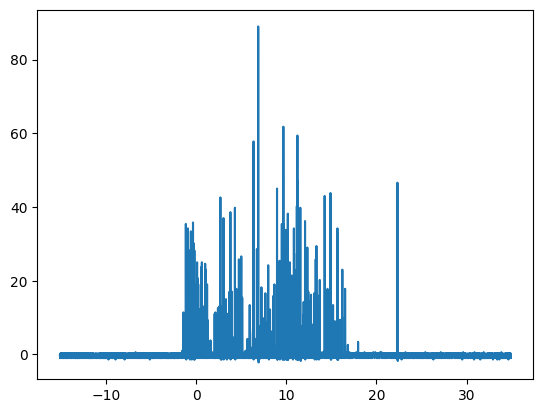

In [252]:
wf = fprox.load_pmt_frame()
plt.plot(wf.t, wf.v)

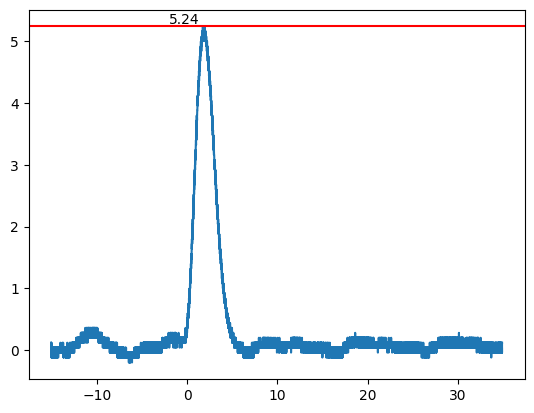

In [161]:
wfa = fprox.load_alpha_frame()
plt.plot(wfa.t, wfa.v)
vmax = wfa.v.max()
plt.axhline(vmax, color='r')
plt.text(-2, vmax*1.01, s=round(vmax, 3));

In [ ]:
alpha_peak(wfa.v)

Max V_corrected:  5.170744679907391
Max V_dithered:  5.189974954633772


np.float64(5.189962493312228)

In [147]:
fprox.uid(), fprox.file_seq, fprox.frame_idx, fprox.chunk_dir

(645,
 10,
 5,
 '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/FieldScan_Gate0050_Anode1950')

In [150]:
find_chunk_for_fileseq(chunk_dir, fprox.file_seq)

'/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/FieldScan_Gate0050_Anode1950/energy_map_f000001-f000010.bin'

In [149]:
fprox.energy

4.904818534851074

In [142]:
get_energy_for_frame(chunk_dir, fprox.file_seq, fprox.frame_idx)

4.904818534851074

# Test s1/s2 timing functions

In [254]:
results = []
uids = []
detector_func=detect_s1_in_frame
threshold_s1=1.0
set_pmt = pset
max_files = 9

for frame_wf in iter_frameproxies(set_pmt, chunk_dir=None, max_files=max_files):

    uid = make_uid(frame_wf.file_seq, frame_wf.frame_idx)
    frame_pmt = frame_wf.load_pmt_frame()
    frame_alpha = frame_wf.load_alpha_frame()
    val = detector_func(frame_pmt, threshold_s1=threshold_s1)
    if val is not None:
        uids.append(uid)
        results.append(val)



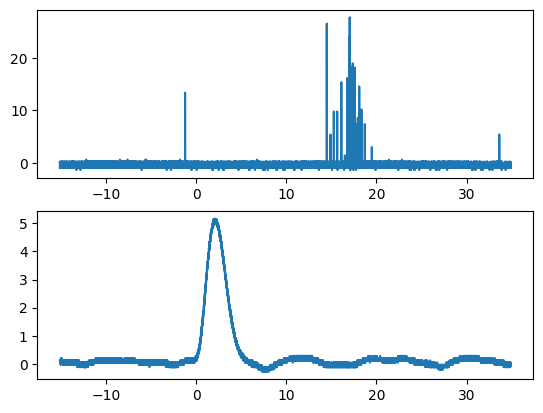

In [255]:
fig, ax = plt.subplots(2)
ax[0].plot(frame_pmt.t, frame_pmt.v)
ax[1].plot(frame_alpha.t, frame_alpha.v)

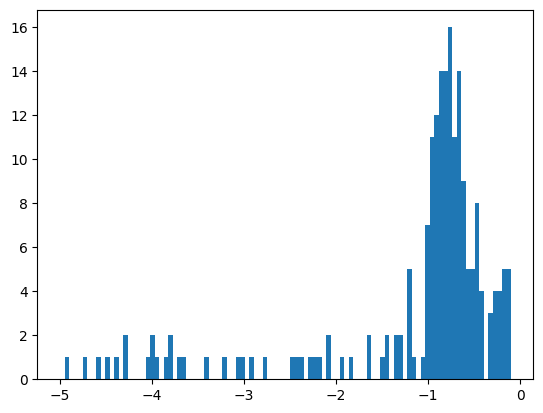

In [257]:
results = np.array(results)
plt.hist(results, bins = 100, range=(-5, -0.1));

In [31]:
upset_s1, s1s, uids_s1 = compute_s1(pset, max_frames=500)

  Computing S1...
  Processing 11 files (~528 frames)
  → t_s1 = -0.824 ± 3.002 µs (from 241 frames)


In [32]:
_, s2s, uids_s2 = compute_s2(upset_s1, max_frames=500, threshold_s2=0.8)

  Computing S2 (expected start: 14.31 µs)...
  Processing 11 files (~528 frames)
  → t_s2_start = 14.502 ± 1.062 µs (from 330 frames)
  → t_s2_end = 18.369 ± 5.048 µs (from 394 frames)
  → s2_duration = 3.998 ± 7.571 µs (from 344 frames)


In [36]:
uids_s2.shape

(426,)

In [40]:
s2s['t_s2_start'].shape, s2s['t_s2_end'].shape, s2s['s2_duration'].shape

((426,), (426,), (426,))

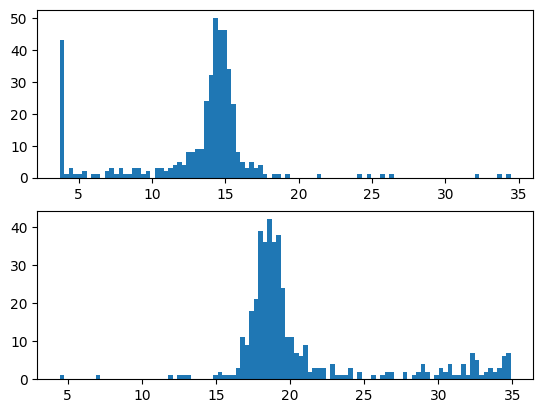

In [284]:
fig, ax = plt.subplots(2)
ax[0].hist(s2s['t_s2_start'], bins=100);
ax[1].hist(s2s['t_s2_end'], bins=100);

# Test full S1/S2 detection workflow

In [75]:
upset = workflow_s1_set(pset)

  Computing S1...
  Processing 5 files (~240 frames)
  → t_s1 = -0.924 ± 2.69 µs (from 119 frames)
    💾 Saved to FieldScan_Gate0100_Anode2000_s1.npz
  → Saved: /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/plots/s1_timing/FieldScan_Gate0100_Anode2000_s1.png


In [68]:
uupset = workflow_s2_set(upset, max_frames=1000, threshold_s2=0.8)

  Computing S2 (expected start: 14.21 µs)...
  Processing 21 files (~1008 frames)
  → t_s2_start = 14.676 ± 1.053 µs (from 635 frames)
  → t_s2_end = 18.755 ± 5.072 µs (from 767 frames)
  → s2_duration = 4.002 ± 7.381 µs (from 669 frames)
    💾 Saved to FieldScan_Gate0100_Anode2000_s2.npz
  → Saved: /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/plots/s2_timing/FieldScan_Gate0100_Anode2000_s2.png


In [76]:
file_s1_out = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/processed_data/FieldScan_Gate0100_Anode2000_s1.npz'
loaded = np.load(file_s1_out, allow_pickle=True)
# loaded['uids'][:4], loaded['times'][:4]
loaded

NpzFile '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/processed_data/FieldScan_Gate0100_Anode2000_s1.npz' with keys: uids, t_s1

In [77]:
file_s2_out = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/processed_data/FieldScan_Gate0100_Anode2000_s2.npz'
loaded_s2 = np.load(file_s2_out, allow_pickle=True)
loaded_s2

NpzFile '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN18_multi/processed_data/FieldScan_Gate0100_Anode2000_s2.npz' with keys: uids, t_s2_start, t_s2_end, s2_duration

In [81]:
loaded_s2['uids'].shape, loaded_s2['t_s2_start'].shape

((824,), (824,))

# Distribute S2 results by isotope

In [86]:
energies = get_energies_for_uids(loaded_s2['uids'], chunk_dir = str(pset.source_dir))

In [104]:
uids_load = loaded_s2['uids']

In [97]:
isot_ranges = {
    'Th228': (4.0, 4.7),
    'Ra224': (4.7, 5.0),
    'Rn220': (5.2, 5.5),
    'Po216': (5.5, 6.0),
    'Po212': (6.0, 10.0)
    }

In [95]:
energies[:10]

array([4.684156  , 5.2715807 , 4.6805515 , 4.364688  , 7.2517667 ,
       4.59026   , 0.44431278, 4.6009536 , 5.5098763 , 3.9125907 ],
      dtype=float32)

In [98]:
for e in energies[:10]:
    print(assign_isotope_by_energy(e, isot_ranges))

Th228
Rn220
Th228
Th228
Po212
Th228
None
Th228
Po216
None


In [163]:
isot_s2 = assign_uids_to_isotopes(uids_load, map_dir=uupset.source_dir, isotope_ranges=isot_ranges)

In [203]:
total_len = 0
for k, v in isot_s2.items():
    total_len += len(v)
    print(len(v))
print('total events in energy range: ', total_len )

224
187
114
94
83
total events in energy range:  702


In [127]:
isot_s2['Th228']

array([  0,   2,   3,   5,   7,  10,  14,  18,  25,  31,  40,  43,  45,
        48,  49,  52,  63,  64,  67,  68,  69,  72,  74,  75,  78,  80,
        83,  86, 101, 106, 108, 112, 114, 118, 120, 122, 131, 136, 137,
       142, 144, 152, 155, 156, 158, 165, 169, 170, 180, 185, 188, 191,
       192, 193, 203, 211, 213, 218, 226, 227, 230, 231, 233, 234, 238,
       241, 242, 248, 249, 250, 256, 262, 265, 272, 279, 285, 299, 300,
       307, 310, 314, 316, 319, 322, 331, 336, 341, 342, 347, 348, 349,
       350, 354, 359, 360, 362, 364, 365, 366, 367, 373, 386, 391, 395,
       396, 400, 402, 408, 410, 418, 419, 423, 424, 425, 429, 431, 440,
       442, 449, 453, 454, 459, 461, 462, 472, 477, 479, 480, 483, 484,
       487, 489, 490, 492, 500, 501, 505, 508, 514, 515, 516, 519, 529,
       531, 533, 534, 538, 546, 548, 554, 558, 559, 563, 572, 576, 577,
       587, 588, 592, 600, 601, 603, 609, 612, 614, 615, 619, 622, 624,
       628, 630, 631, 633, 634, 635, 638, 639, 640, 641, 646, 65

In [124]:
s2_map = {}
for uid, start, end in zip(loaded_s2['uids'], loaded_s2['t_s2_start'], loaded_s2['t_s2_end']):
    s2_map[uid] = (start, end)

In [199]:
loaded_s2['uids'].shape

(824,)

In [164]:
s2_map

{np.uint32(641): (np.float64(14.78), np.float64(18.522399999999998)),
 np.uint32(642): (np.float64(3.8651999999999966), np.float64(32.4662)),
 np.uint32(643): (np.float64(13.962399999999999),
  np.float64(18.299000000000003)),
 np.uint32(644): (np.float64(15.764), np.float64(18.107999999999997)),
 np.uint32(645): (np.float64(3.6183999999999976), np.float64(22.337)),
 np.uint32(647): (np.float64(13.285199999999998),
  np.float64(13.288799999999998)),
 np.uint32(648): (np.float64(3.6173999999999986),
  np.float64(34.430800000000005)),
 np.uint32(650): (np.float64(12.360799999999998), np.float64(18.6536)),
 np.uint32(653): (np.float64(14.273999999999997),
  np.float64(18.772000000000002)),
 np.uint32(655): (np.float64(15.432399999999998), np.float64(17.7534)),
 np.uint32(656): (np.float64(13.665599999999998), np.float64(17.7686)),
 np.uint32(657): (np.float64(14.690399999999999), np.float64(17.3696)),
 np.uint32(658): (np.float64(14.604399999999996), np.float64(19.463)),
 np.uint32(659): 

In [168]:
timing_dict = {}
for name, uids in isot_s2.items():
    for uid in uids:
        try:
            t_start, t_end = s2_map[uid]
            timing_dict[uid] = [name, t_start, t_end]
        except KeyError:
            pass

In [195]:
timing_df = pd.DataFrame(timing_dict).T
timing_df.columns = ['isotope', 't_s2_start', 't_s2_end']
grouped_start = list(timing_df.groupby('isotope')['t_s2_start'])
grouped_end = list(timing_df.groupby('isotope')['t_s2_end'])

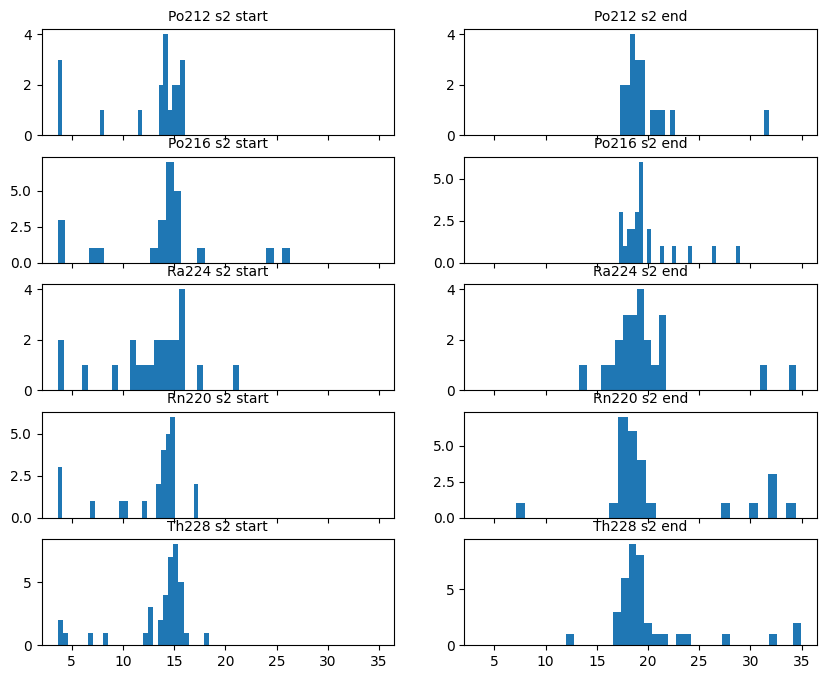

In [215]:
fig, ax = plt.subplots(len(grouped_start), 2, 
                       figsize = (10, 8),
                       sharex=True)
for j, isot in enumerate(range(len(grouped_start))):
    name, val_isot = grouped_start[isot]
    ax[j][0].hist(val_isot, bins=30)
    ax[j][0].set_title(name + ' s2 start', fontsize=10)
for j, isot in enumerate(range(len(grouped_end))):
    name, val_isot = grouped_end[isot]
    ax[j][1].hist(val_isot, bins=30)
    ax[j][1].set_title(name + ' s2 end', fontsize=10)


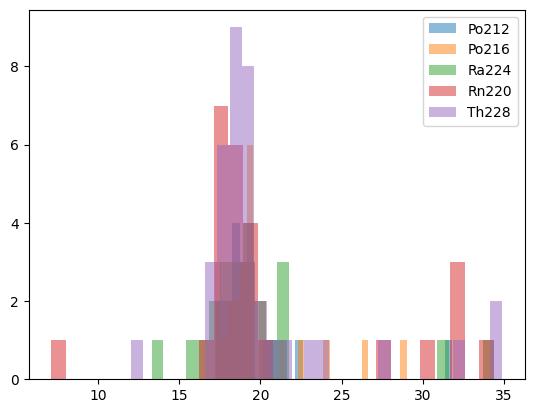

In [197]:
for isot in range(len(grouped_end)):
    name, val_isot = grouped_end[isot]
    plt.hist(val_isot, bins=30, alpha=0.5, label=name)
plt.legend()

# Test S2 integration set level